# 2023-01-11
Neural Nets from scratch

In [101]:
from typing import List, Optional, Callable
from numpy.typing import NDArray
import numpy as np

np.random.seed(42)

import matplotlib.pyplot as plt

$\text{Softplus} = f(x) = \log{(1+e^x)}$

In [102]:
# activation functions

def softplus(x: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.log(1 + np.exp(x))

def tanh(x: NDArray[np.float64]) -> NDArray[np.float64]:
    return np.tanh(x)

def tanh_prime(x: NDArray[np.float64]) -> NDArray[np.float64]:
    return 1 - np.tanh(x)**2

In [103]:
# Define loss functions

def mse(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.mean(np.power((y_true - y_pred), 2))

def mse_prime(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return 2 * (y_pred - y_true) / y_true.size

In [107]:
# layers definitions

class Layer:
    def __init__(self) -> None:
        self._input: NDArray[np.float64] = None
        self._output: NDArray[np.float64] = None

    def display(self) -> None:
        raise NotImplementedError

    def forward_propagation(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        raise NotImplementedError

    def backward_propagation(self, output_error: float, lr: float) -> NDArray[np.float64]:
        raise NotImplementedError

class FCLayer(Layer):
    # output_size - number of nodes in the hidden layer
    def __init__(self, input_size: int, output_size: int) -> None:
        self._weights = np.random.rand(input_size, output_size) - 0.5
        self._bias = np.random.rand(1, output_size) - 0.5

    def display(self) -> str:
        return "\n".join(["[]" * self._weights.shape[0], "()" * self._weights.shape[1]])

    def forward_propagation(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        self._input = input
        self._output = np.dot(self._input, self._weights) + self._bias
        return self._output

    def backward_propagation(self, output_error: float, lr: float) -> NDArray[np.float64]:
        input_error = np.dot(output_error, self._weights.T)
        weights_error = np.dot(self._input.T, output_error)

        self._weights -= lr * weights_error
        self._bias -= lr * output_error

        # here we return output error of the FC layer
        return input_error

class ActivationLayer(Layer):
    def __init__(self, activation: Callable, activation_prime: Callable) -> None:
        self._activation = activation
        self._activation_prime = activation_prime

    def forward_propagation(self, input: NDArray[np.float64]) -> NDArray[np.float64]:
        self._input = input
        self._output = self._activation(input)
        return self._output

    def display(self) -> str:
        return "(Activation)"

    def backward_propagation(self, output_error: float, lr: float) -> NDArray[np.float64]:
        # here we return output error of Activation Layer
        return self._activation_prime(self._input) * output_error

In [108]:
# network definition

class Network:
    def __init__(self, layers: List[Layer], loss: Callable, loss_prime: Callable, ) -> None:
        self._loss = loss
        self._loss_prime = loss_prime
        self._layers = layers

        self._training_loss: List[float] = []

    def _plot_loss(self) -> None:
        plt.plot(self._training_loss)
        plt.title("Training loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        result: NDArray[np.float64] = np.array([], dtype=np.float64)

        for i in range(x.shape[0]):
            output = x[i]
            for layer_num, layer in enumerate(self._layers):
                output = layer.forward_propagation(output)
            result = np.append(result, output)
        
        return result

    def __str__(self) -> str:
        return "\n".join(layer.display() for layer in self._layers)

    def fit(self, x_train: NDArray[np.float64], y_train: NDArray[np.float64], lr: float = 1e-3, epochs: int = 100, x_val: Optional[NDArray[np.float64]] = None, y_val: Optional[NDArray[np.float64]] = None):
        for i in range(epochs):
            err: float = 0.0
            for j in range(x_train.shape[0]):
                # Calculate output
                output = x_train[j]

                for layer in self._layers:
                    output = layer.forward_propagation(output)
                
                # Determine loss
                err += self._loss(y_train[j], output)
                
                # Determine how output affects MSE
                error = self._loss_prime(y_train[j], output)
                
                for layer in reversed(self._layers):
                    error = layer.backward_propagation(error, lr)
    

            self._training_loss.append(err / x_train.shape[0])
            if i % 100 == 0:
                print(f"Epoch {i}, training_loss: {err / x_train.shape[0]}")
            
        self._plot_loss()



![](./nn.png)

1. $x_{1,i}=\text{Input}_{i} \cdot w_{1}+b_{1}$
2. $x_{2,i}=\text{Input}_{i} \cdot w_{2}+b_{2}$
4. $y_{1,i}=f(x_{1,j})=\text{Softplus}(x_{1,j})=\log{(1+e^x_{1,i})}$
5. $y_{2,i}=f(x_{2,j})=\text{Softplus}(x_{2,j})=\log{(1+e^x_{2,i})}$
6. $\text{Output}=y_{1,i} \cdot w_{3} + y_{2,i} \cdot w_{4} + b3$

In [109]:
network = Network(layers=[
    FCLayer(1, 2),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(2, 1)
], loss=mse, loss_prime=mse_prime)

print(network)

[]
()()
(Activation)
[][]
()


In [10]:
network.predict(np.array([1, 2, 3]))

array([-0.2149209 , -0.1454346 , -0.09568127])

## Solving XOR using our network

In [14]:
# Define training data

x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

In [26]:
network = Network(layers=[
    FCLayer(2, 5),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(5, 1),
    ActivationLayer(tanh, tanh_prime)
], loss=mse, loss_prime=mse_prime)

print(network)

[][]
()()()()()
(Activation)
[][][][][]
()
(Activation)


Epoch 0, training_loss: 0.3479787595126763
Epoch 100, training_loss: 0.19173800592638343
Epoch 200, training_loss: 0.005534955161634084
Epoch 300, training_loss: 0.001712221653630204
Epoch 400, training_loss: 0.000957922297525167
Epoch 500, training_loss: 0.0006518159617313212
Epoch 600, training_loss: 0.0004890038476744011
Epoch 700, training_loss: 0.0003889260422126871
Epoch 800, training_loss: 0.00032157902850006646
Epoch 900, training_loss: 0.00027335300112822533


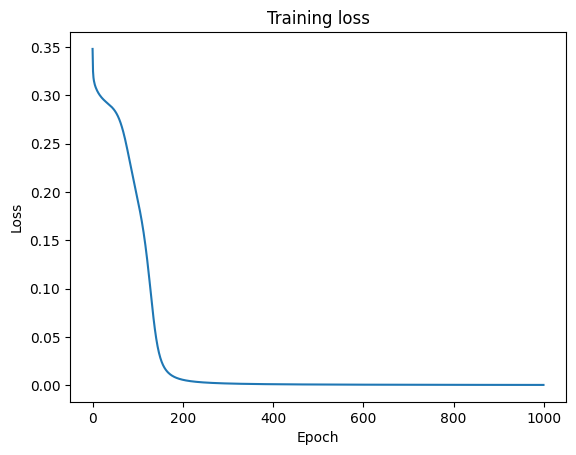

In [27]:
network.fit(x_train, y_train, lr=0.1, epochs=1000)

In [28]:
network.predict(x_train)

array([ 8.14658192e-04,  9.78623348e-01,  9.77865347e-01, -1.20637384e-03])

In [29]:
np.round(network.predict(x_train))

array([ 0.,  1.,  1., -0.])

## Using our neural network to classify Irises

In [30]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [151]:
iris = load_iris()
x = iris.data
y = iris.target

# converting category number to one hot vector
y = np.eye(3)[y]

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [110]:
network = Network(layers=[
    FCLayer(4, 3),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(3, 3),
    ActivationLayer(tanh, tanh_prime)
], loss=mse, loss_prime=mse_prime)

Epoch 0, training_loss: 0.2420679105157027
Epoch 100, training_loss: 0.02804553664653525
Epoch 200, training_loss: 0.02324244065365719
Epoch 300, training_loss: 0.021510323179976365


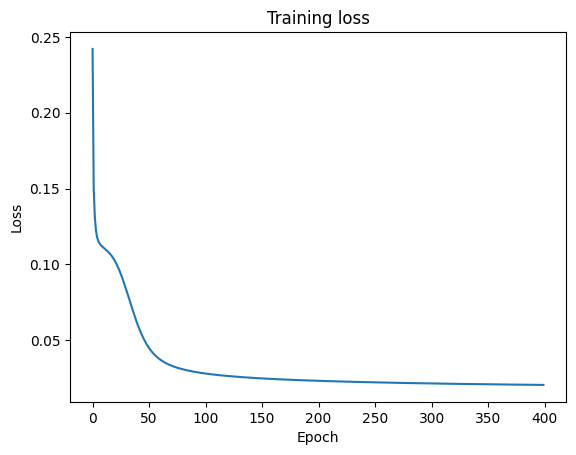

In [111]:
network.fit(np.reshape(x_train, (112, 1, 4)), y_train, lr=0.01, epochs=400)

In [112]:
samples_size = x_test.shape[0]

preds = np.argmax(network.predict(x_test).reshape(samples_size,3), axis=1)

In [113]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



# MNITS classification

In [158]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import pandas as pd

In [159]:
x = load_digits()["data"]
y = load_digits()["target"]

x = np.reshape(x, (1797, 1, 64))
y = pd.get_dummies(y).values

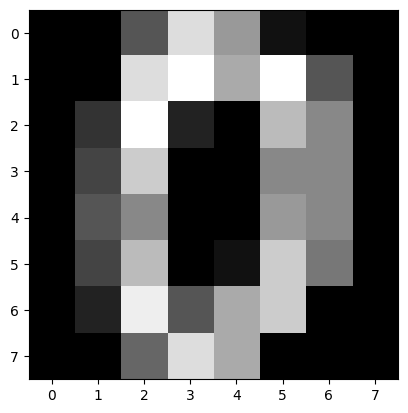

In [163]:
plt.imshow(x.reshape(1797, 8, 8)[0], cmap="gray")

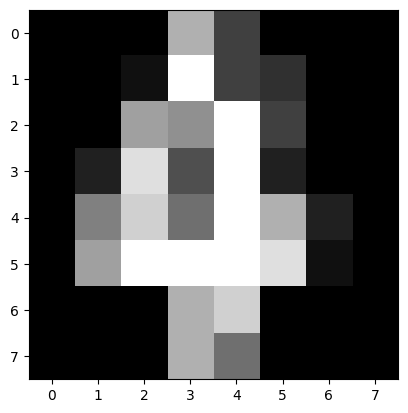

In [162]:
plt.imshow(x.reshape(1797, 8, 8)[400], cmap="gray")

In [167]:
# Scaling values from 0 to 1
x = x / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [186]:
network = Network(layers=[
    FCLayer(64, 32),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(32, 16),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(16, 9),
    ActivationLayer(tanh, tanh_prime),
    FCLayer(9, 10),
    ActivationLayer(tanh, tanh_prime)
], loss=mse, loss_prime=mse_prime)

Epoch 0, training_loss: 0.12497652441406662


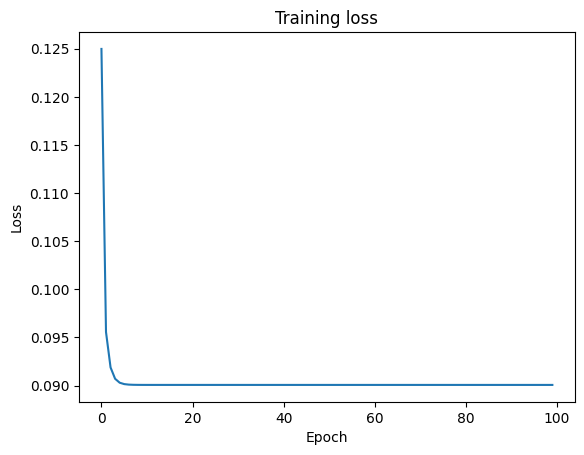

In [187]:
network.fit(x_train, y_train, epochs=100)

In [188]:
samples_size = x_test.shape[0]

preds = np.argmax(network.predict(x_test).reshape(samples_size,10), axis=1)

In [198]:
import copy

network_copy = copy.copy(network)

In [205]:
network_copy._layers.pop(-1)

In [206]:
network_copy.predict(x_test[:10]).reshape(10, 3, 3)

array([[[ 0.44768185,  0.38158315, -0.51952056],
        [ 0.0684688 ,  0.36637619, -0.01681697],
        [-0.43531184, -0.1773716 ,  0.01664135]],

       [[ 0.44767986,  0.38158177, -0.51952056],
        [ 0.06846791,  0.36637483, -0.01681606],
        [-0.43531252, -0.17737203,  0.01664183]],

       [[ 0.44767942,  0.38158369, -0.5195199 ],
        [ 0.0684692 ,  0.3663748 , -0.01681733],
        [-0.43531115, -0.17737095,  0.01664192]],

       [[ 0.44768164,  0.38158297, -0.51951986],
        [ 0.06846822,  0.36637501, -0.0168165 ],
        [-0.435313  , -0.17737414,  0.01664003]],

       [[ 0.44767951,  0.38158362, -0.51952079],
        [ 0.06846885,  0.36637598, -0.01681781],
        [-0.43531153, -0.17737005,  0.01664272]],

       [[ 0.44767862,  0.38158526, -0.51951831],
        [ 0.06846894,  0.36637446, -0.01681513],
        [-0.43531216, -0.17737343,  0.01664037]],

       [[ 0.44767984,  0.38158306, -0.51951947],
        [ 0.06846807,  0.36637492, -0.01681671],
        

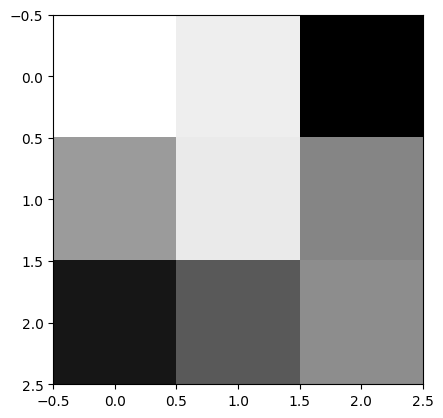

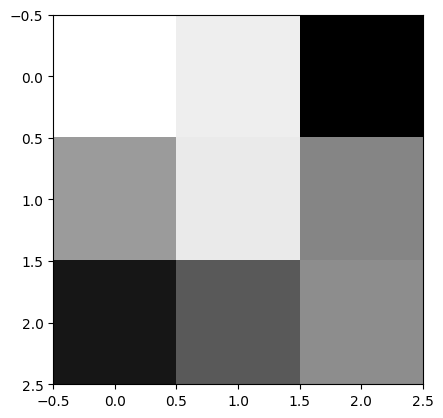

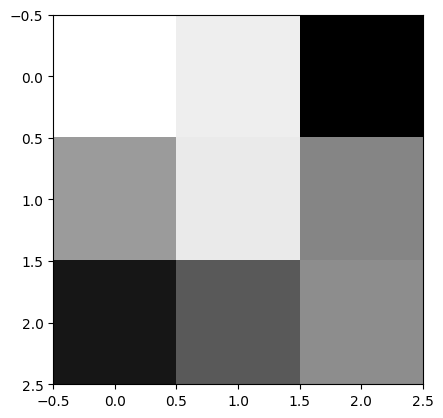

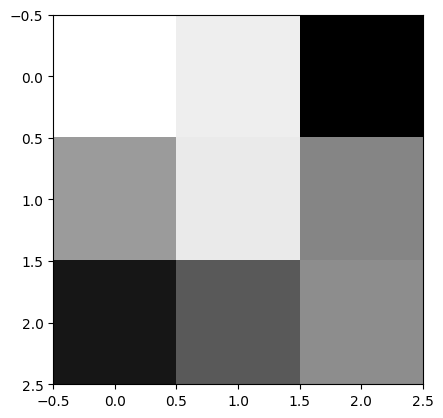

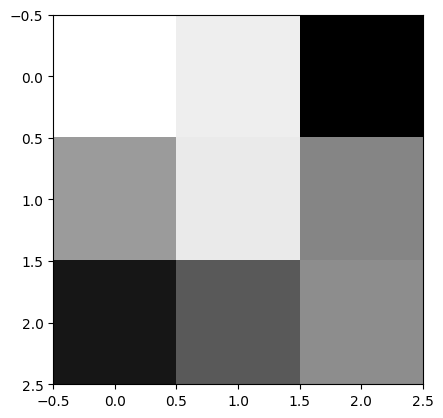

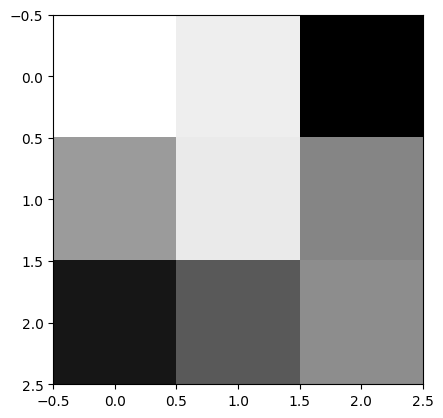

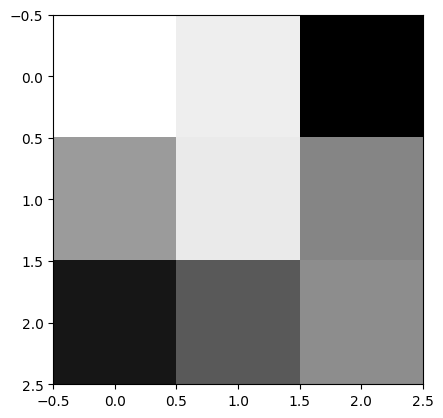

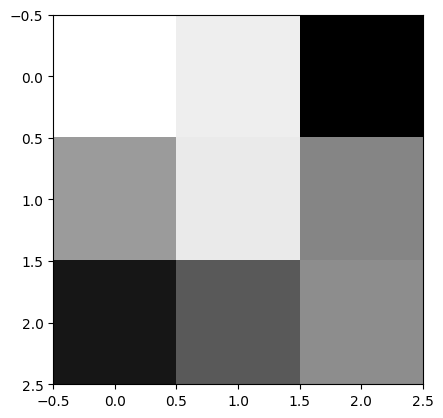

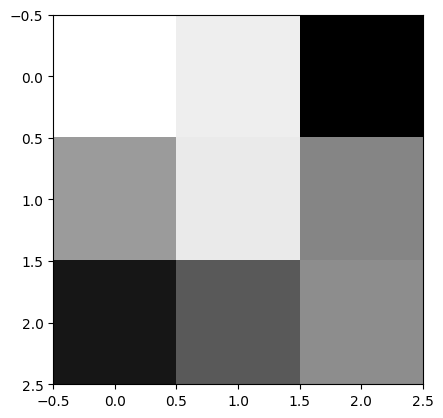

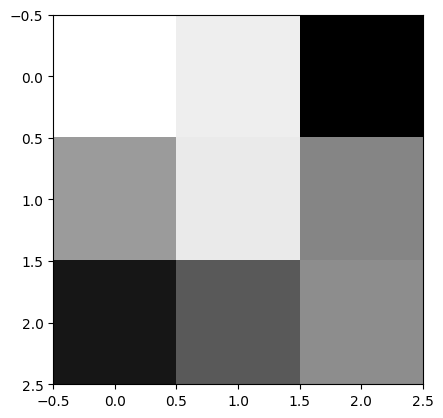

In [208]:
for im in network_copy.predict(x_test[:10]).reshape(10, 3, 3):
    plt.imshow(im, cmap="gray")
    plt.show()

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, 

In [214]:
x, y = load_planar_dataset()

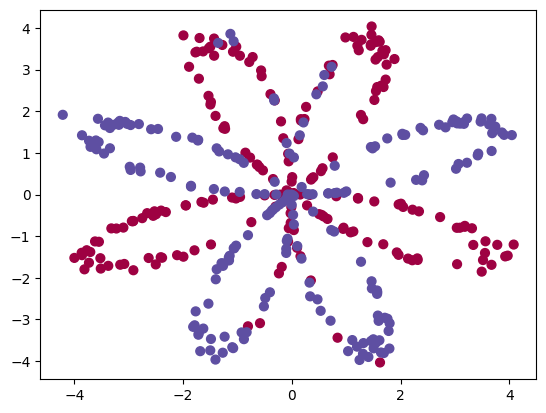

In [215]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);